# Estimate car price - More Exploratory Data Analysis

### Introduction
-  Learn from previous sales of used cars to estimate price of further used vehicles
-  Push calculations down to SAP HANA. Leverage the in-memory performance directly out of Python without data extraction.

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a HANA DataFrame, which points to the imputed view. The data remains in SAP HANA.

In [1]:
# Obtain logon details from the central Connection Management of SAP Data Intelligence
import hana_ml.dataframe as dataframe

# Instantiate connection object
from notebook_hana_connector.notebook_hana_connector import NotebookConnectionContext
conn = NotebookConnectionContext(connectionId='HANADB')

# Create the HANA dataframe in the structure of the specified table / view
df_pushdown = conn.table("USEDCARPRICES_IMP_VIEW", schema="TAXX")

### Peek at the data and retrieve a small number of rows

In [2]:
df_pushdown.head(3).collect()

,GEARBOX_IMP,CAR_ID,VEHICLETYPE,NAME,MODEL,YEAR,HP,FUELTYPE,KILOMETER,DAMAGED,PRICE
0,manual,16,limousine,Mercedes_C_200_Kompressor,C-Class,2000.0,160.0,petrol,150000.0,no,2300.0
1,manual,69,limousine,C_180_mit_TÜV,C-Class,1995.0,122.0,petrol,150000.0,no,600.0
2,gearbox unknown,82,limousine,Mercedes_Benz_C_230,C-Class,1996.0,150.0,petrol,150000.0,no,800.0


### Get row count

In [3]:
df_pushdown.count()

25019

### Get column statistics

In [4]:
df_pushdown.describe().collect()

,column,count,unique,nulls,mean,std,min,max,median,25_percent_cont,25_percent_disc,50_percent_cont,50_percent_disc,75_percent_cont,75_percent_disc
0,CAR_ID,25019,25019,0,13424.032415,7776.415290,0.0,26899.0,13390.0,6691.5,6691.0,13390.0,13390.0,20156.5,20157.0
1,YEAR,25019,67,0,2002.468244,7.290506,1910.0,2016.0,2003.0,1999.0,1999.0,2003.0,2003.0,2007.0,2007.0
2,HP,25019,298,0,165.297894,181.967244,0.0,20000.0,150.0,122.0,122.0,150.0,150.0,197.0,197.0
3,KILOMETER,25019,13,0,128822.295056,36844.260846,5000.0,150000.0,150000.0,125000.0,125000.0,150000.0,150000.0,150000.0,150000.0
4,PRICE,25019,1936,0,10343.689076,89273.425129,0.0,14000500.0,6399.0,2900.0,2900.0,6399.0,6399.0,13000.0,13000.0
5,GEARBOX_IMP,25019,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,VEHICLETYPE,25019,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NAME,25019,13933,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,MODEL,25019,18,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,FUELTYPE,25019,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Category frequency by Model

In [5]:
top_n = 5

# Get Top N categories
df_pushdown_col_frequency = df_pushdown.agg([('count', 'MODEL', 'COUNT')],  group_by='MODEL')
df_col_frequency = df_pushdown_col_frequency.sort("COUNT", desc=True).head(top_n).collect()
print(df_col_frequency)

     MODEL  COUNT
0  C-Class   6509
1  E-Class   5366
2  A-Class   2867
3    Other   2618
4      CLK   1377


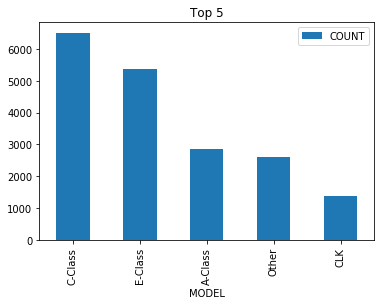

In [6]:
%matplotlib inline 
df_col_frequency.plot.bar(x='MODEL', y="COUNT", title="Top " + str(top_n));

### Inspect price against year on sample data

In [10]:
#!pip install seaborn

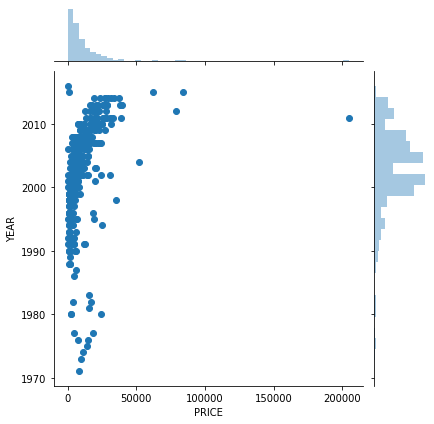

In [11]:
# Scatterplot
n_sample_size = 500
col_name_1 = 'PRICE'
col_name_2 = 'YEAR'

# Sort on the random columna and retrieve the sample to a local DataFrame
df_pushdown_sample = df_pushdown.select(df_pushdown.columns, ('RAND()', 'RAND'))
df_sample = df_pushdown_sample.sort("RAND", desc=True).select(col_name_1, col_name_2).head(n_sample_size).collect()

import seaborn as sns
sns.jointplot(x=col_name_1, y=col_name_2, data=df_sample);

### Display outliers

In [12]:
# Display most expensive vehicles
df_pushdown.filter('"PRICE" > 200000').sort("PRICE", desc=True).collect()

,GEARBOX_IMP,CAR_ID,VEHICLETYPE,NAME,MODEL,YEAR,HP,FUELTYPE,KILOMETER,DAMAGED,PRICE
0,automatic,20301,coupe,Mercedes_Benz_CLK_Coupe_280_7G_TRONIC_Sport_Av...,CLK,2008.0,231.0,petrol,125000.0,no,14000500.0
1,manual,9924,cabrio,Mercedes_Benz_300_d_Cabriolet__W189_,Other,1960.0,160.0,petrol,5000.0,no,585000.0
2,automatic,24460,cabrio,Mercedes_Benz_SLR_McLaren_Roadster,Other,2010.0,625.0,petrol,30000.0,no,368000.0
3,automatic,24002,limousine,Mercedes_Benz_C_63_AMG_7G_TRONIC,C-Class,2009.0,457.0,petrol,100000.0,no,350000.0
4,automatic,15944,cabrio,Mercedes_Benz_SLS_AMG_Roadster_AMG_SPEEDSHIFT_DCT,Other,2013.0,571.0,petrol,10000.0,no,237500.0
5,automatic,8778,coupe,Mercedes_Benz_SLS_AMG_Coupe_Flechtleder_B&O_1....,Other,2010.0,571.0,petrol,10000.0,no,225000.0
6,automatic,6361,coupe,Mercedes_Benz_SLS_AMG_Coupe_AMG_SPEEDSHIFT_DCT,Other,2010.0,571.0,petrol,50000.0,no,214800.0
7,automatic,10476,coupe,Mercedes_Benz_SLS_AMG_Coupe_Alubeam_1._Hand,Other,2011.0,571.0,petrol,50000.0,no,205000.0
8,manual,23090,cabrio,Mercedes_Benz_300_Adenauer_Cabrio,Other,1952.0,116.0,petrol,100000.0,no,205000.0


### Save outliers to file

In [13]:
# Retrieve the data into a local dataframe
df_outliers = df_pushdown.filter('"PRICE" > 200000').sort("PRICE", desc=True).collect()
df_outliers.to_csv("most_expensive_cars.csv", sep=";" ,  index = False)

### Obtain specific percentile

In [14]:
# Hardcoded
sql = 'SELECT PERCENTILE_CONT(0.1) WITHIN GROUP (ORDER BY PRICE ASC) FROM TAXX.USEDCARPRICES_IMP_VIEW'
df_pushdown_percentile = conn.sql(sql)
df_temp = df_pushdown_percentile.collect()
print(float(df_temp.iloc[0:,0]))

1500.0


In [15]:
# Parameterised
schemaName = 'TAXX'
tableName = 'USEDCARPRICES_IMP_VIEW'
columnName = 'PRICE'
percentile = 0.1

sql = ('SELECT PERCENTILE_CONT(' + str(percentile) +') WITHIN GROUP (ORDER BY ' + columnName + ' ASC) ' +
       ' FROM ' + schemaName + '.' + tableName )
df_pushdown_percentile = conn.sql(sql)
df_temp = df_pushdown_percentile.collect()
print(float(df_temp.iloc[0:,0]))

1500.0


### Obtain wider range of percentiles

In [16]:
import pandas as pd
import numpy as np

schemaName = 'TAXX'
tableName = 'USEDCARPRICES_IMP_VIEW'
columnName = 'PRICE'
df_percentiles = pd.DataFrame(columns=['PERCENTILE', 'VALUE'])

step = 5
for i in range(0, 100 + step, step):
    percentile = i / 100
    sql = ('SELECT PERCENTILE_CONT(' + str(percentile) +') WITHIN GROUP (ORDER BY ' + columnName + ' ASC) ' +
       ' FROM ' + schemaName + '.' + tableName )
    
    df_pushdown_percentile = conn.sql(sql)
    df_temp = df_pushdown_percentile.collect()
    percentile_value = round(float(df_temp.iloc[0:,0]), 2)
    df_percentiles = df_percentiles.append({'PERCENTILE': percentile, 'VALUE': percentile_value}, ignore_index = True)

In [17]:
# Display percentiles
df_percentiles

,PERCENTILE,VALUE
0,0.00,0.0
1,0.05,1000.0
2,0.10,1500.0
3,0.15,1940.0
4,0.20,2400.0
5,0.25,2900.0
6,0.30,3499.0
7,0.35,3999.0
8,0.40,4799.0
9,0.45,5500.0


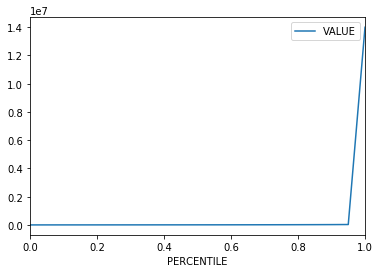

In [18]:
# Plot percentiles
import matplotlib.pyplot as plt
lines = df_percentiles.plot.line(x='PERCENTILE', y='VALUE')

### Filter on cars built from the year 2000 onwards costing under 50k Euro

In [19]:
df_pushdown = df_pushdown.filter('"YEAR" >= 2000')
df_pushdown = df_pushdown.filter('"PRICE" < 50000')
df_pushdown.count()

18333

### Correlations

In [20]:
# Get list of numerical columns for full correlation matrix
import numpy as np
# Get  names of numeric columns
numeric_cols = []
all_cols = df_pushdown.drop(["CAR_ID"]).columns
for col_name in all_cols:
    if df_pushdown.is_numeric(col_name):
        numeric_cols.append(col_name)
print("Numerical columns: " + str(numeric_cols))

Numerical columns: ['YEAR', 'HP', 'KILOMETER', 'PRICE']


In [21]:
# Calculate correlation matrix for all numerical columns
from hana_ml.algorithms.pal import stats
df_corr_matrix = stats.pearsonr_matrix(conn, df_pushdown, cols=numeric_cols).collect() 
df_corr_matrix

,ID,YEAR,HP,KILOMETER,PRICE
0,YEAR,1.000000,0.096238,-0.536630,0.750964
1,HP,0.096238,1.000000,-0.023013,0.298412
2,KILOMETER,-0.536630,-0.023013,1.000000,-0.545549
3,PRICE,0.750964,0.298412,-0.545549,1.000000


In [22]:
# Adjust data frame for the heatmap
import pandas as pd
df_corr_matrix = df_corr_matrix.drop('ID', 1)
df_corr_matrix.index=numeric_cols

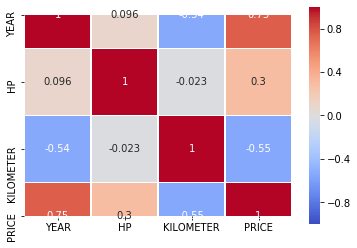

In [23]:
# Plot correlation matrix
import seaborn as sns
sns.heatmap(df_corr_matrix, cmap="coolwarm", linewidths=.5, square=True, vmin=-1, vmax=1, annot=True);

### Save adjusted data as view

In [24]:
df_pushdown.save(where=("TAXX", "USEDCARPRICES_PREP_VIEW"), table_type="VIEW")

### Close connection

In [25]:
conn.close()